In [ ]:
# TODO: include start and end of feature, include prefix and suffix info

In [ ]:
# Read book: Data Without Labels (Manning Publ.)

In [ ]:
# https://python-charts.com/correlation/clustermap-seaborn/

In [1]:
import collections, os

import numpy as np
import pandas as pd
import seaborn as sns

In [27]:
LEX_CUT_OFF = 10

files = [
         'nouns_adjectives.csv', 
         #'infa_qal.csv',
         #'infc_qal_lamed_he.csv', 
         #'infc_qal_triliteral.csv', 
         #'niph_hiph_pe_yod.csv', 
         'ptca_qal.csv', 
         'ptcp_qal.csv',
         #'hiphil_triliteral_with_hireq.csv'
]
path = '../data'

In [144]:
#collect tuples
# (spelling info, lexeme)

scroll_book_dict = collections.defaultdict(lambda: collections.defaultdict(list))

for file in files:
    dat = pd.read_csv(os.path.join(path, file), sep='\t')

    feature_name = file.split('.')[0]
    print(feature_name)
    #print(dat.columns)

    dat['book2'] = dat.book.str.replace('1_', '').replace('2_', '')
    dat['book2'] = dat.book2.str.replace('2_', '')
    
    #dat = dat[dat.scroll != 'SP']
    
    # split 1QIsaa in two halves
    dat['scroll2'] = [scr + '_I' if scr == '1Qisaa' and chapter < 34 else scr + '_II' if scr == '1Qisaa' and chapter >= 34 else scr for scr, chapter in zip(dat.scroll, dat.chapter)]
    
    if feature_name == 'hiphil_triliteral_with_hireq':
        dat = dat[dat.has_hireq == '1']
        
    if feature_name == 'nouns_adjectives':
        dat['lex_type'] = dat.lex + '_' + dat.type
        lex_vl_counts = pd.crosstab(dat.lex_type, dat.vowel_letter).T

        lex_vl = lex_vl_counts.idxmax()
        lex_vl_df = pd.DataFrame(lex_vl)
        lex_vl_df.columns = ['lex_vl']
        dat = pd.merge(dat, lex_vl_df, how='left', on=['lex_type'])

        dat.loc[dat['lex_vl'] == 'J', 'lex_vl'] = 'Y'

        # Remove aleph
        dat = dat[dat['lex_vl'] != '>']
        
      
    for idx, row in dat.iterrows():
        
        scroll = row.scroll2
        book = row.book2
        lex = row.lex
        typ = row.type
        has_vl = row.has_vowel_letter
       
        has_suffix = str(int(row.has_hloc) or int(row.has_nme) or int(row.has_prs))
        
        if feature_name == 'nouns_adjectives':
            spelling_info = '_'.join([feature_name, typ, row.lex_vl, has_suffix, str(has_vl)])
            feature_info = (feature_name + '_' + typ + '_' + row.lex_vl, lex)
        else:
            spelling_info = '_'.join([feature_name, typ, has_suffix, str(has_vl)])
            feature_info = (feature_name + '_' + typ, lex)
        
        scroll_book_dict[scroll + '_' + book][feature_info].append(spelling_info)
        

nouns_adjectives
ptca_qal
ptcp_qal


In [145]:
all_features = set()
book_feature_counts = collections.defaultdict(int)

for scr_book, feat_lex_dict in scroll_book_dict.items():
    features_in_one_book = collections.defaultdict(int)
    
    for (feature, lex), spelling_list in feat_lex_dict.items():
        feature_count = collections.Counter(spelling_list)
        all_features.update(spelling_list)
        for feature, count in feature_count.items():
            features_in_one_book[feature] += min(LEX_CUT_OFF, count)
           
        book_feature_counts[scr_book] = features_in_one_book

In [146]:
sorted_features = sorted(list(all_features))

In [147]:
sorted_features

['nouns_adjectives_first_W_0_0',
 'nouns_adjectives_first_W_0_1',
 'nouns_adjectives_first_W_1_0',
 'nouns_adjectives_first_W_1_1',
 'nouns_adjectives_first_Y_0_0',
 'nouns_adjectives_first_Y_0_1',
 'nouns_adjectives_first_Y_1_0',
 'nouns_adjectives_first_Y_1_1',
 'nouns_adjectives_last_W_0_0',
 'nouns_adjectives_last_W_0_1',
 'nouns_adjectives_last_W_1_0',
 'nouns_adjectives_last_W_1_1',
 'nouns_adjectives_last_Y_0_0',
 'nouns_adjectives_last_Y_0_1',
 'nouns_adjectives_last_Y_1_0',
 'nouns_adjectives_last_Y_1_1',
 'nouns_adjectives_single_W_0_0',
 'nouns_adjectives_single_W_0_1',
 'nouns_adjectives_single_W_1_0',
 'nouns_adjectives_single_W_1_1',
 'nouns_adjectives_single_Y_0_0',
 'nouns_adjectives_single_Y_0_1',
 'nouns_adjectives_single_Y_1_0',
 'nouns_adjectives_single_Y_1_1',
 'ptca_qal_first_0_0',
 'ptca_qal_first_0_1',
 'ptca_qal_first_1_0',
 'ptca_qal_first_1_1',
 'ptcp_qal_last_0_0',
 'ptcp_qal_last_0_1',
 'ptcp_qal_last_1_0',
 'ptcp_qal_last_1_1']

In [148]:
features = {}

for scr_book, feature_counts in book_feature_counts.items():
    counts_list = []
    for feat in sorted_features:
        counts_list.append(feature_counts.get(feat, 0))
    
    if sum(counts_list) > 80:
        features[scr_book] = counts_list
    
counts = pd.DataFrame(features).T
counts.columns = sorted_features

In [149]:
# remove columns with sum lower than 11
counts = counts[counts.columns[counts.sum()>10]]

In [150]:
counts.columns

Index(['nouns_adjectives_first_W_0_0', 'nouns_adjectives_first_W_0_1',
       'nouns_adjectives_first_W_1_0', 'nouns_adjectives_first_W_1_1',
       'nouns_adjectives_first_Y_0_0', 'nouns_adjectives_first_Y_0_1',
       'nouns_adjectives_first_Y_1_0', 'nouns_adjectives_first_Y_1_1',
       'nouns_adjectives_last_W_0_0', 'nouns_adjectives_last_W_0_1',
       'nouns_adjectives_last_W_1_0', 'nouns_adjectives_last_W_1_1',
       'nouns_adjectives_last_Y_0_0', 'nouns_adjectives_last_Y_0_1',
       'nouns_adjectives_last_Y_1_0', 'nouns_adjectives_last_Y_1_1',
       'nouns_adjectives_single_W_0_0', 'nouns_adjectives_single_W_0_1',
       'nouns_adjectives_single_W_1_0', 'nouns_adjectives_single_W_1_1',
       'nouns_adjectives_single_Y_0_0', 'nouns_adjectives_single_Y_0_1',
       'nouns_adjectives_single_Y_1_0', 'nouns_adjectives_single_Y_1_1',
       'ptca_qal_first_0_0', 'ptca_qal_first_0_1', 'ptca_qal_first_1_0',
       'ptca_qal_first_1_1', 'ptcp_qal_last_0_0', 'ptcp_qal_last_0_1',
    

In [151]:
counts.head()

,nouns_adjectives_first_W_0_0,nouns_adjectives_first_W_0_1,nouns_adjectives_first_W_1_0,nouns_adjectives_first_W_1_1,nouns_adjectives_first_Y_0_0,nouns_adjectives_first_Y_0_1,nouns_adjectives_first_Y_1_0,nouns_adjectives_first_Y_1_1,nouns_adjectives_last_W_0_0,nouns_adjectives_last_W_0_1,...,nouns_adjectives_single_Y_1_0,nouns_adjectives_single_Y_1_1,ptca_qal_first_0_0,ptca_qal_first_0_1,ptca_qal_first_1_0,ptca_qal_first_1_1,ptcp_qal_last_0_0,ptcp_qal_last_0_1,ptcp_qal_last_1_0,ptcp_qal_last_1_1
MT_Genesis,63,15,36,29,2,6,17,4,75,95,...,5,5,100,12,75,4,0,18,11,8
MT_Exodus,96,30,44,22,1,2,7,9,126,135,...,1,12,95,9,71,0,1,17,11,4
MT_Leviticus,70,40,53,29,0,0,4,0,74,70,...,12,1,43,5,29,0,1,14,4,12
MT_Numbers,67,29,30,29,13,1,4,7,78,112,...,6,5,77,8,66,2,2,13,20,27
MT_Deuteronomy,57,23,36,23,2,2,6,2,53,118,...,8,11,103,12,68,2,2,34,8,24


In [152]:
# DIVIDE BY ROW_SUMS
# Every book has the same weight

row_sums = counts.sum(axis=1)
counts_norm = counts.divide(row_sums, axis='rows')

counts_norm.shape

(49, 32)

In [153]:
#counts_norm per feature

countsT = counts.T
row_sumsT = countsT.sum(axis=1)
counts_normT = countsT.divide(row_sumsT, axis='rows')
counts_norm_per_feature = counts_normT.T


In [154]:
counts_norm_per_feature.sum(axis=0)

nouns_adjectives_first_W_0_0     1.0
nouns_adjectives_first_W_0_1     1.0
nouns_adjectives_first_W_1_0     1.0
nouns_adjectives_first_W_1_1     1.0
nouns_adjectives_first_Y_0_0     1.0
nouns_adjectives_first_Y_0_1     1.0
nouns_adjectives_first_Y_1_0     1.0
nouns_adjectives_first_Y_1_1     1.0
nouns_adjectives_last_W_0_0      1.0
nouns_adjectives_last_W_0_1      1.0
nouns_adjectives_last_W_1_0      1.0
nouns_adjectives_last_W_1_1      1.0
nouns_adjectives_last_Y_0_0      1.0
nouns_adjectives_last_Y_0_1      1.0
nouns_adjectives_last_Y_1_0      1.0
nouns_adjectives_last_Y_1_1      1.0
nouns_adjectives_single_W_0_0    1.0
nouns_adjectives_single_W_0_1    1.0
nouns_adjectives_single_W_1_0    1.0
nouns_adjectives_single_W_1_1    1.0
nouns_adjectives_single_Y_0_0    1.0
nouns_adjectives_single_Y_0_1    1.0
nouns_adjectives_single_Y_1_0    1.0
nouns_adjectives_single_Y_1_1    1.0
ptca_qal_first_0_0               1.0
ptca_qal_first_0_1               1.0
ptca_qal_first_1_0               1.0
p

In [155]:
from scipy.stats import zscore
counts_z = counts.apply(zscore)
#print(counts_z)
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
counts_standard = sc.fit_transform(counts)


In [156]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

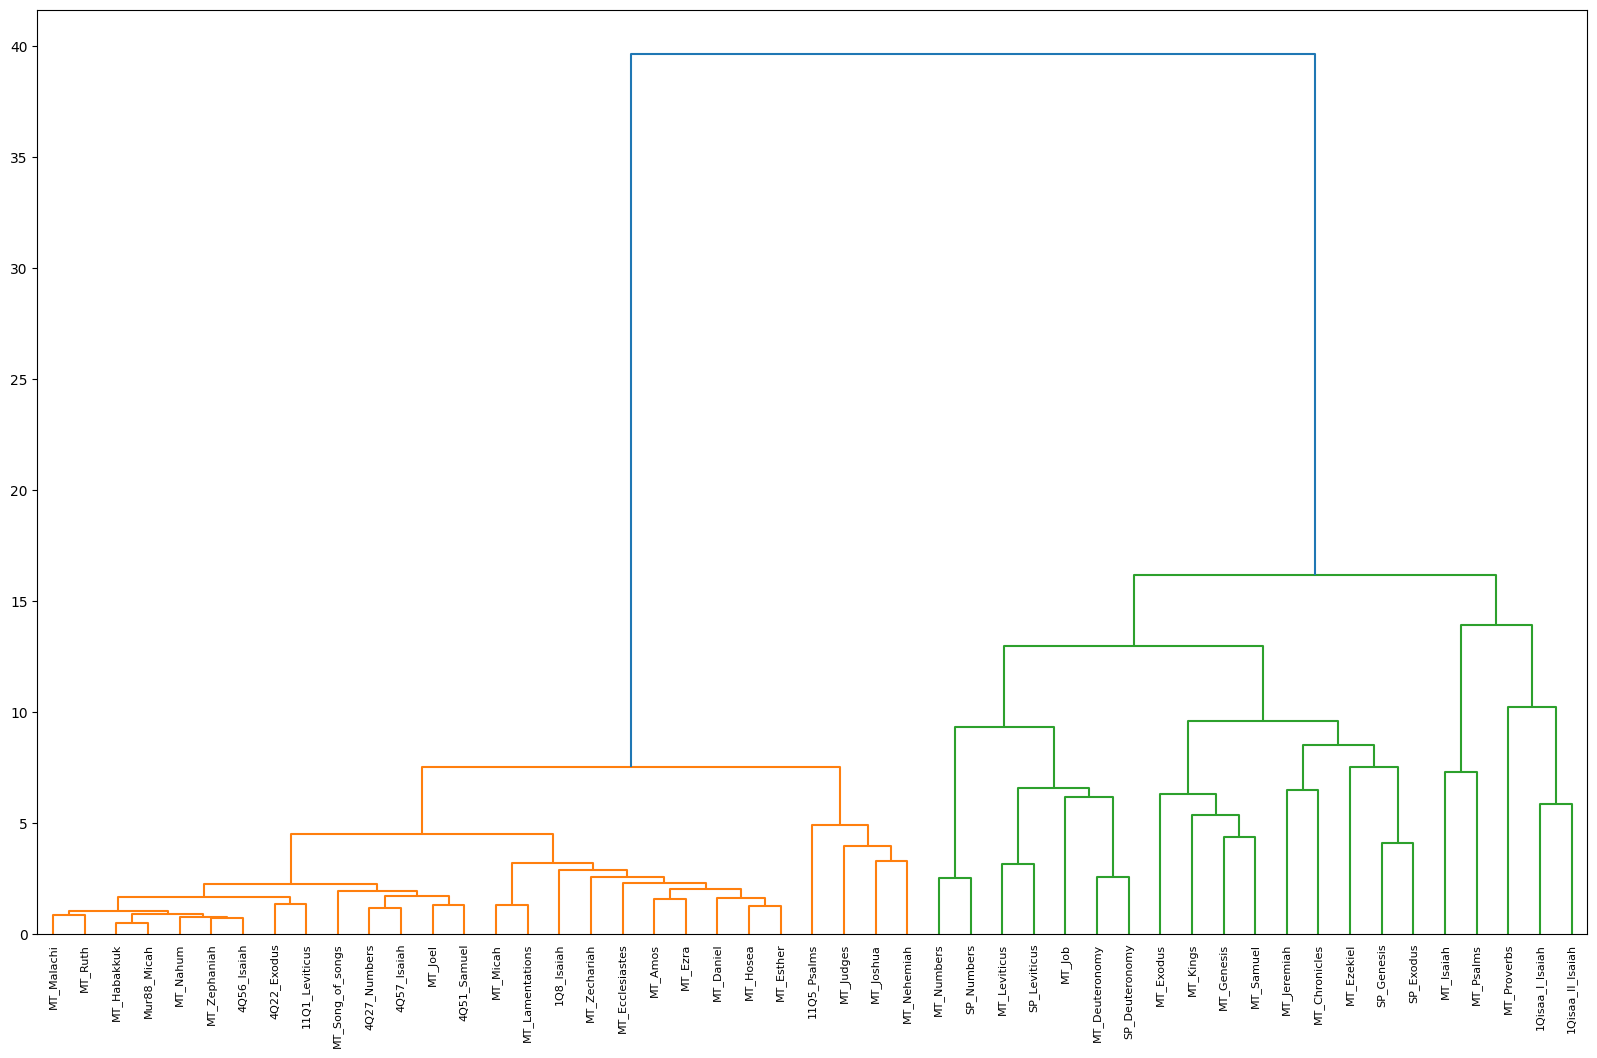

In [157]:
linkage_data = linkage(counts_standard, method='ward', metric='euclidean')

plt.figure(figsize=(20, 12))
dendrogram(linkage_data, labels=counts.index)
plt.show()

In [158]:
import os
os.getcwd()

'C:\\Users\\geitb\\Kopenhagen\\KopenhagenResearch\\scripts_research\\hebrew_spelling_variation\\notebooks'

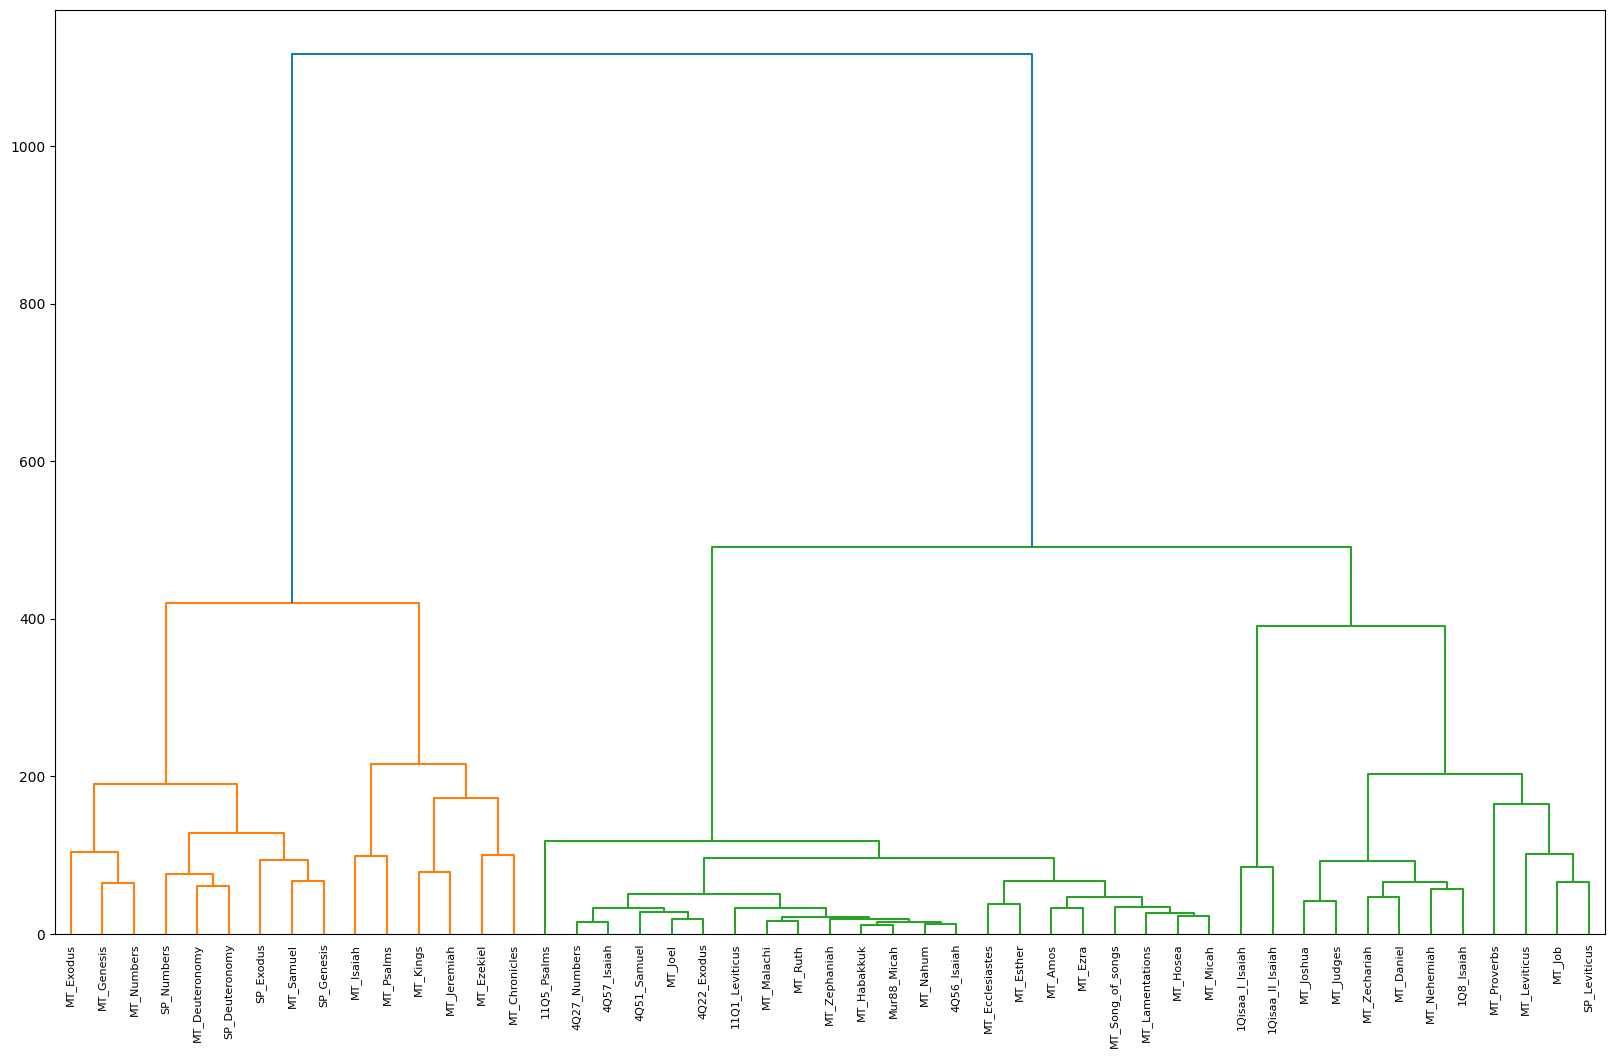

In [159]:
linkage_data = linkage(counts, method='ward', metric='euclidean')

plt.figure(figsize=(20, 12))
dendrogram(linkage_data, labels=counts.index)
plt.show()

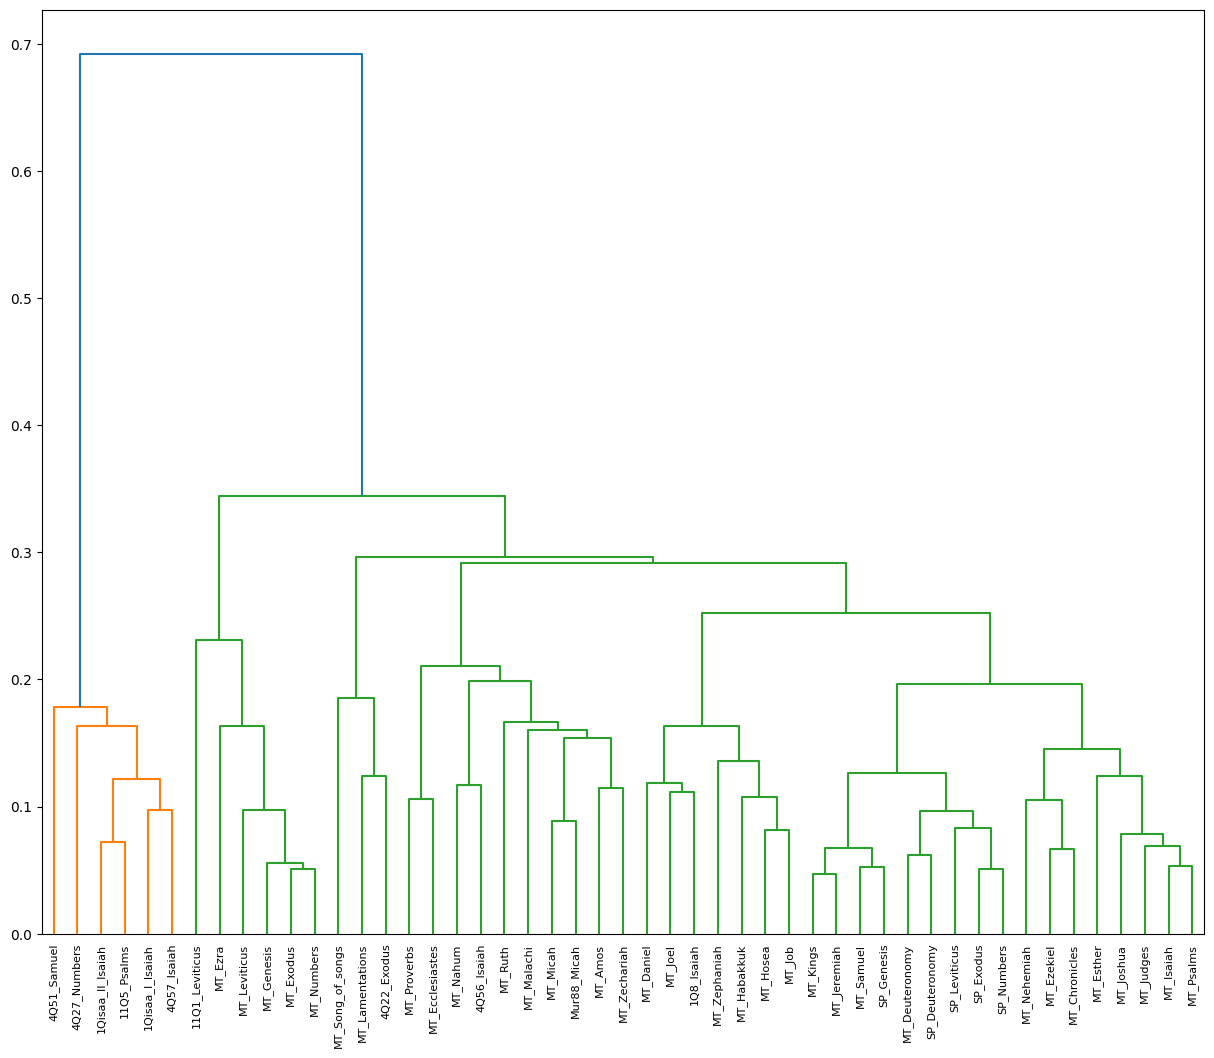

In [160]:
linkage_data = linkage(counts_norm, method='ward', metric='euclidean')

plt.figure(figsize=(15, 12))
dendrogram(linkage_data, labels=counts.index)
#plt.show()

plt.savefig(f'hierarch_clust_counts_norm_lex_cut_off{LEX_CUT_OFF}.png')

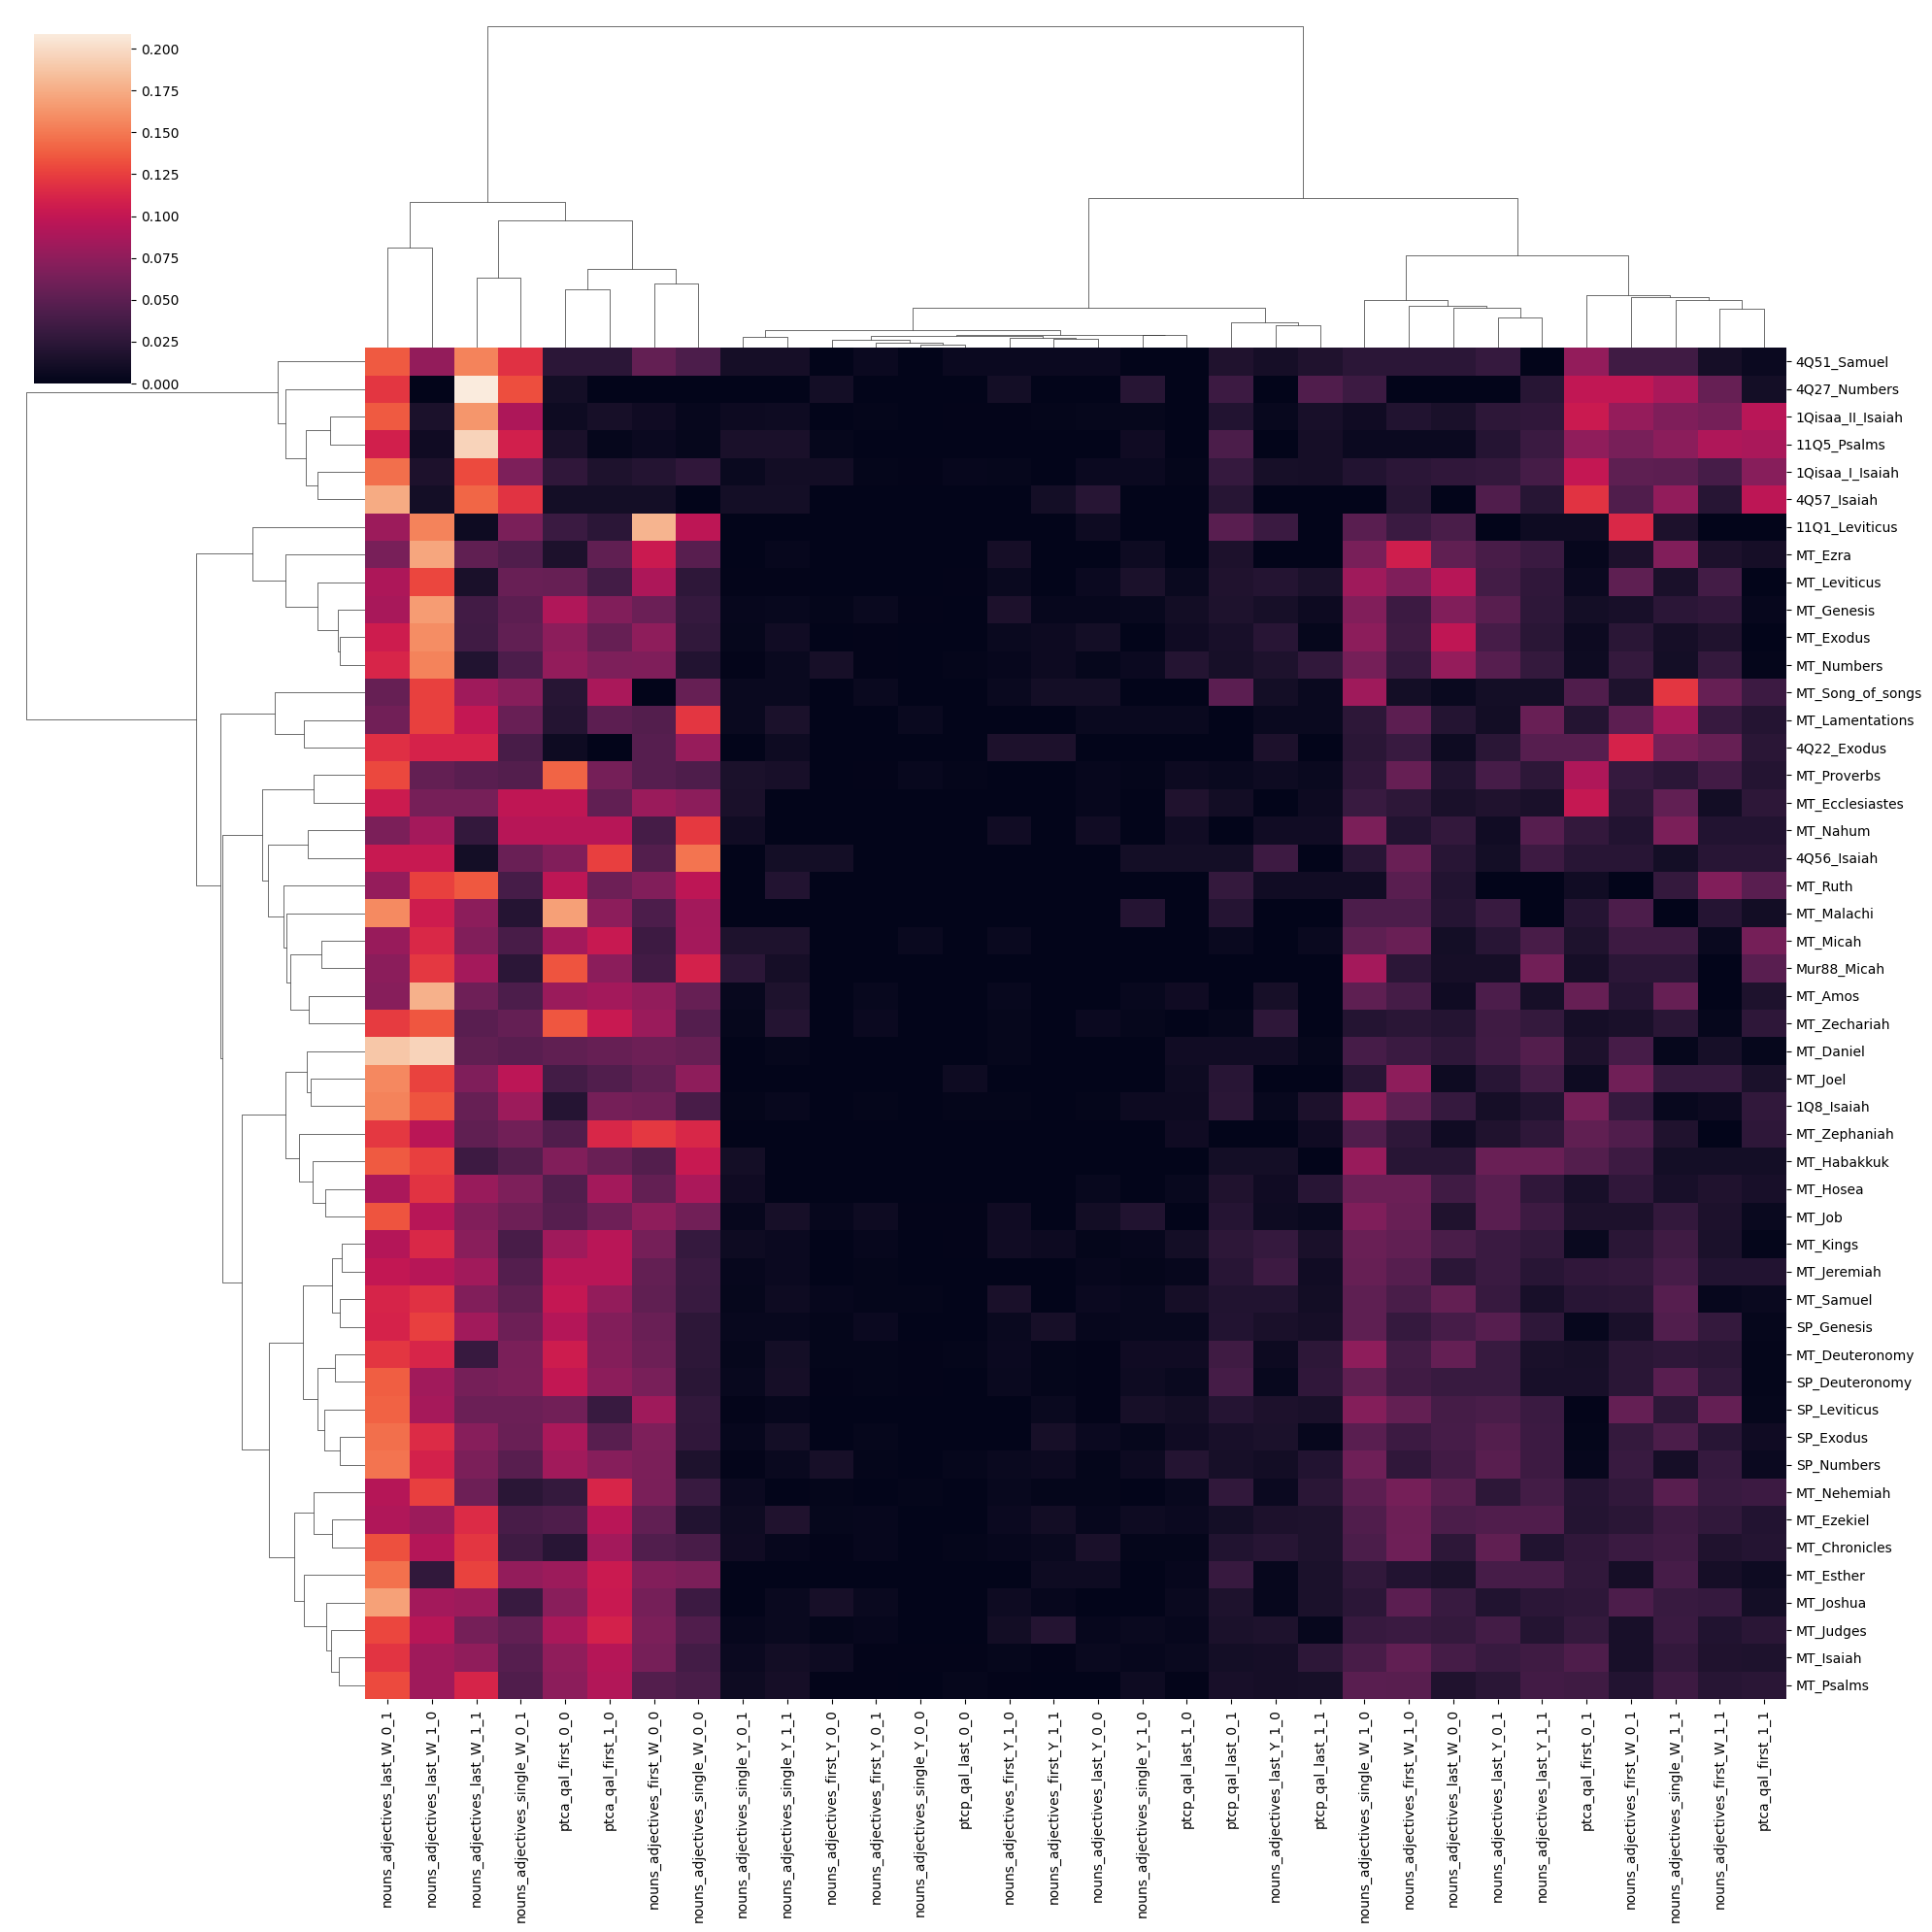

In [161]:
sns.clustermap(counts_norm,
               figsize = (20, 20), 
               method='ward', 
               metric='euclidean')

plt.savefig(f'hierarch_clust_counts_norm_heatmap_lex_cut_off{LEX_CUT_OFF}_for_book_summary.png')

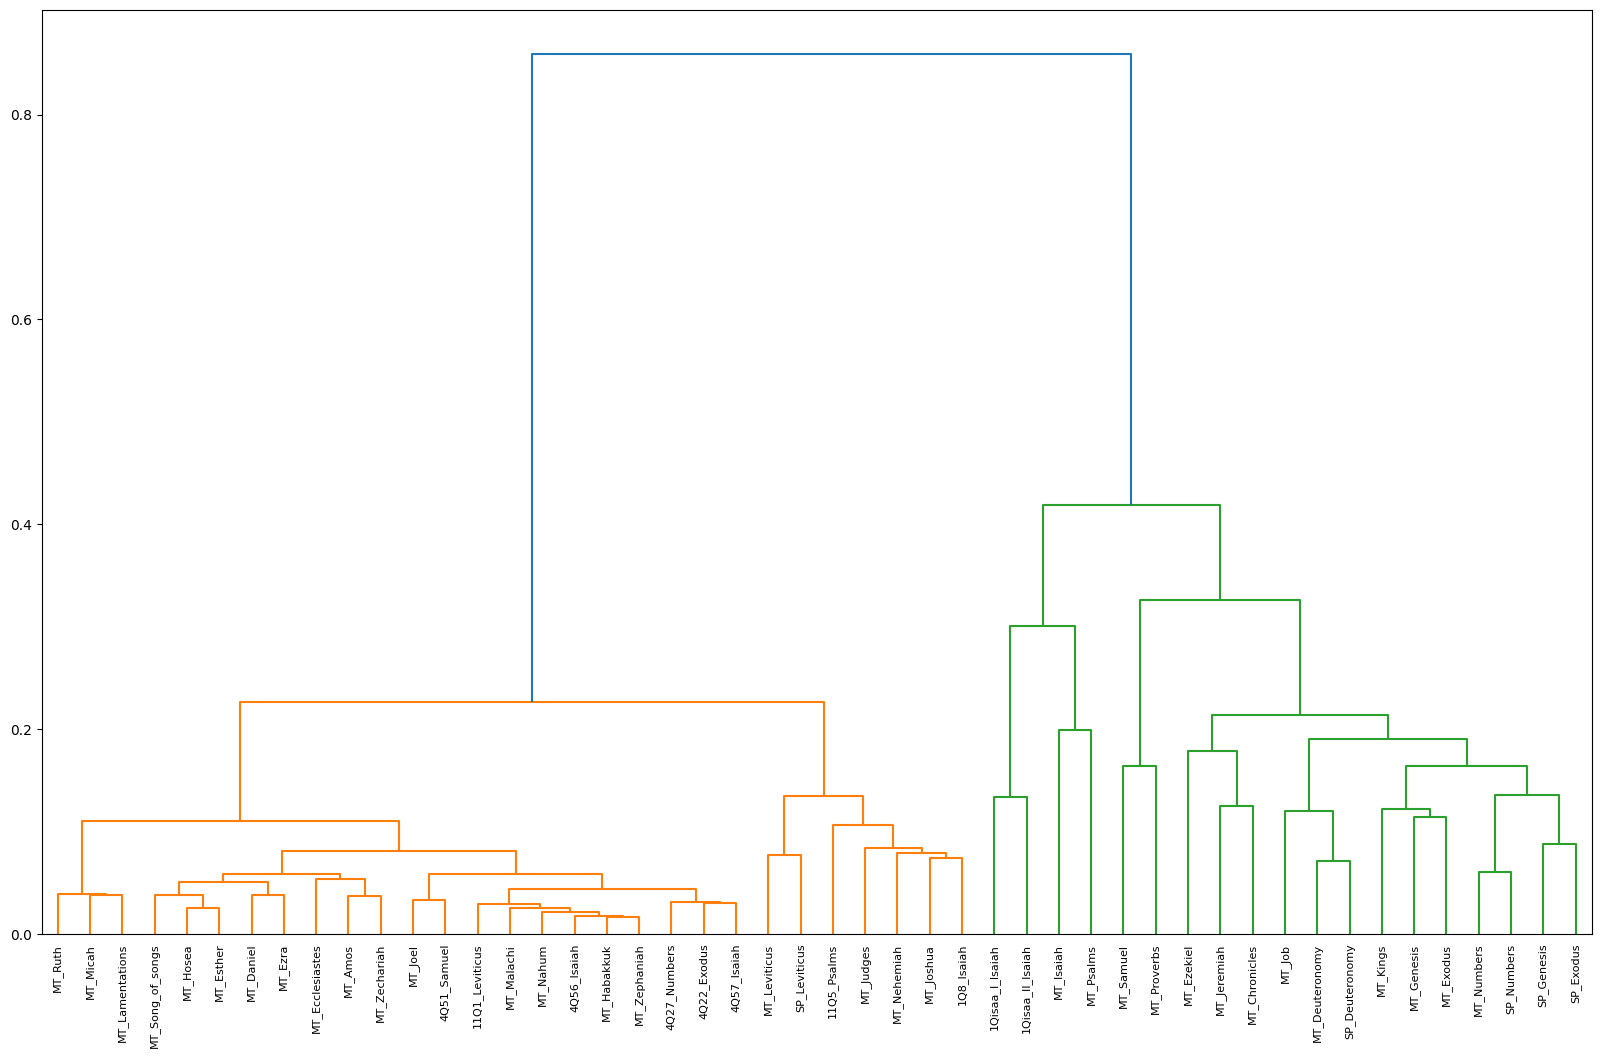

In [23]:
linkage_data = linkage(counts_norm_per_feature, method='ward', metric='euclidean')

plt.figure(figsize=(20, 12))
dendrogram(linkage_data, labels=counts.index)
#plt.show()

plt.savefig('hierarch_clust_counts_norm_per_feature.png')

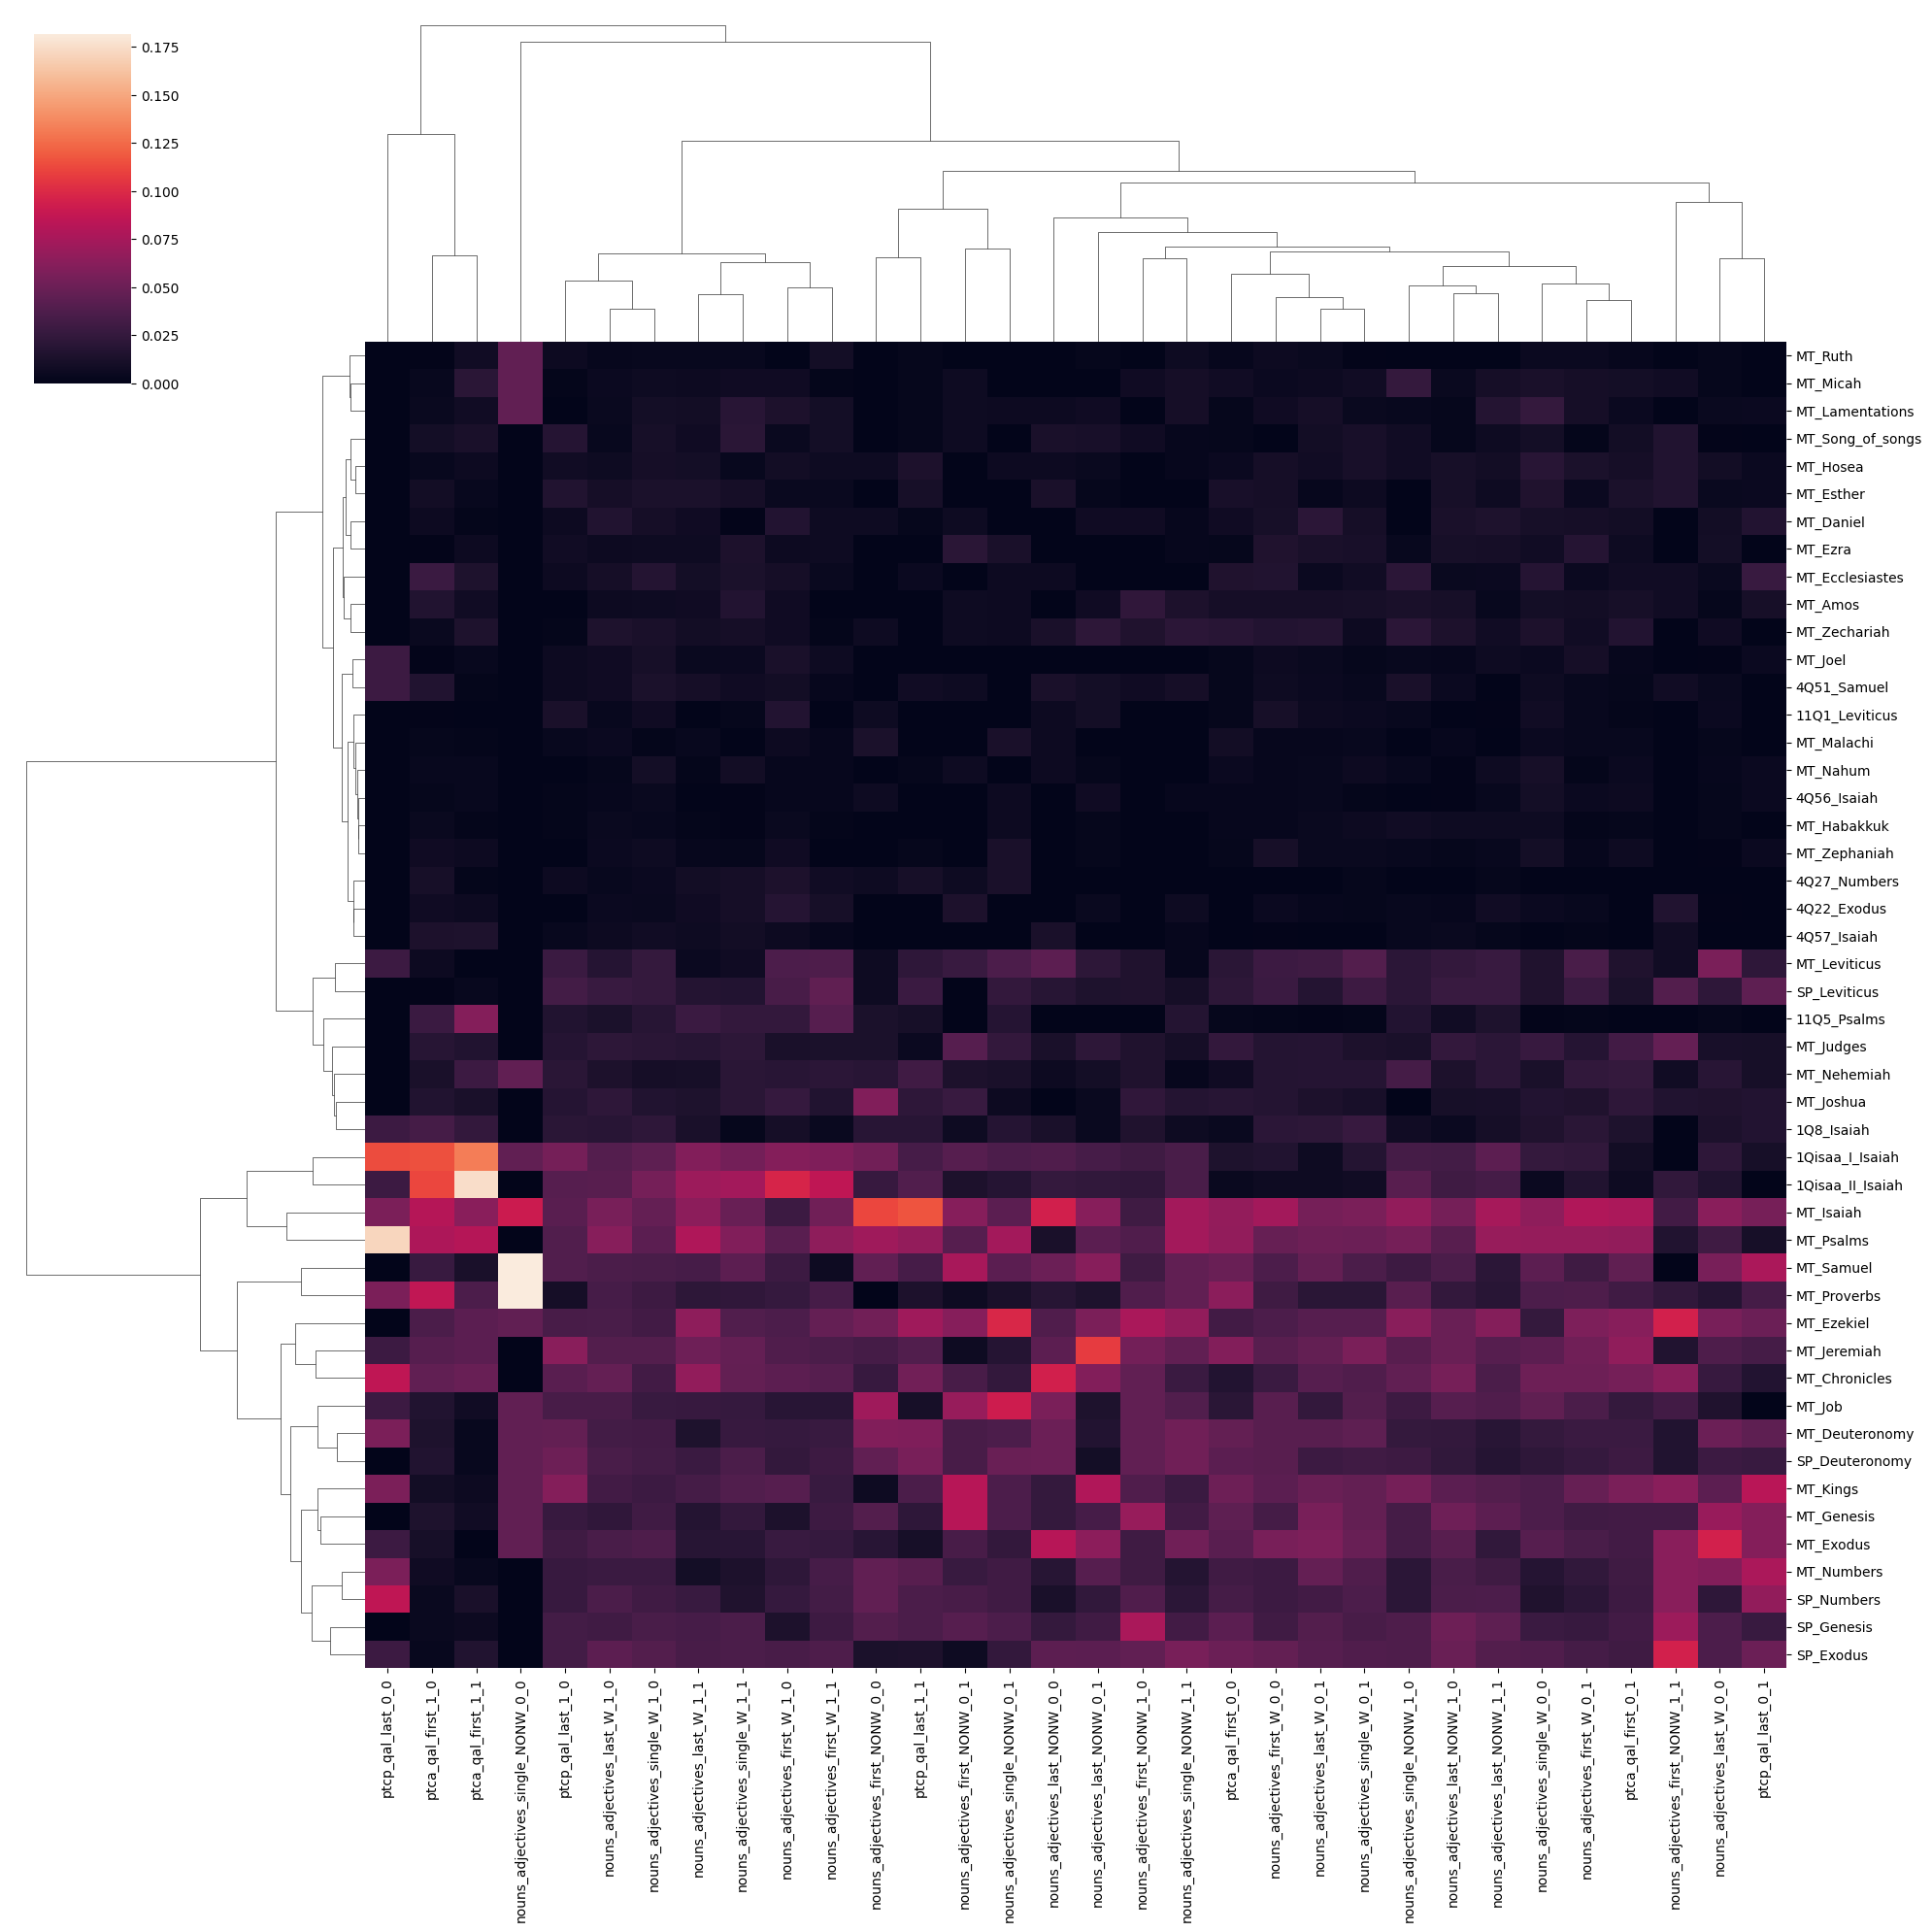

In [24]:
sns.clustermap(counts_norm_per_feature,
               figsize = (20, 20), 
               method='ward', 
               metric='euclidean')

plt.savefig('hierarch_clust_counts_norm_per_feature_heatmap.png')

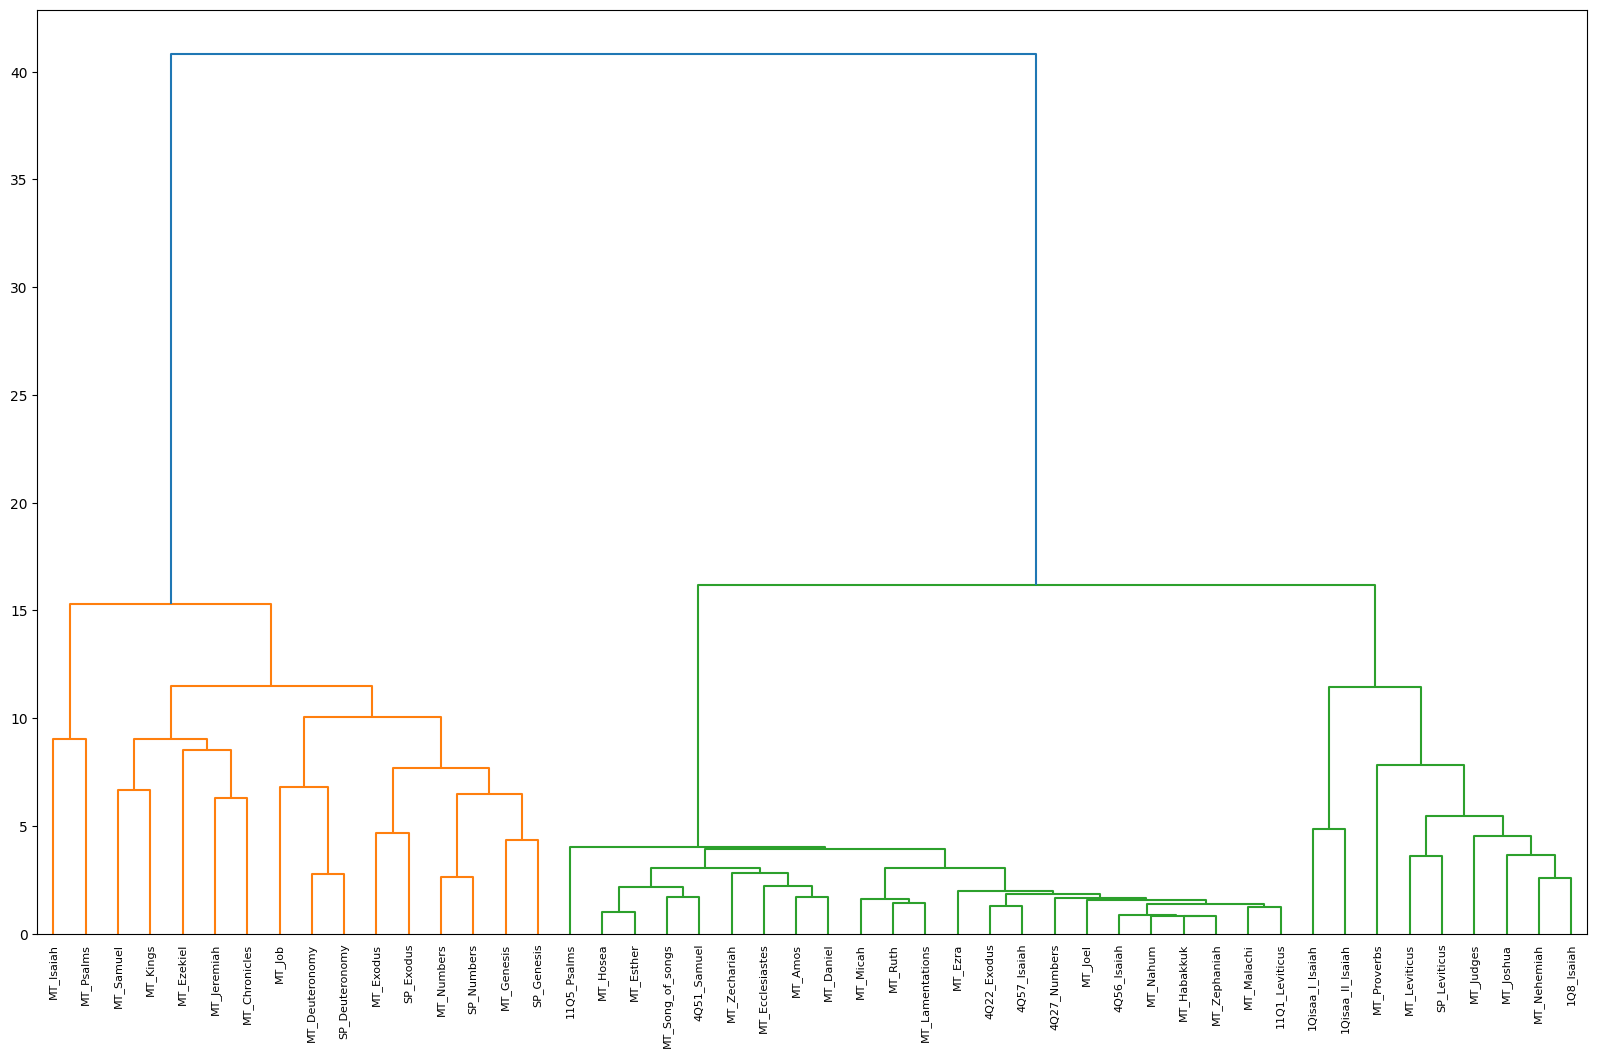

In [25]:
linkage_data = linkage(counts_tf_idf, method='ward', metric='euclidean')

plt.figure(figsize=(20, 12))
dendrogram(linkage_data, labels=counts.index)
plt.show()

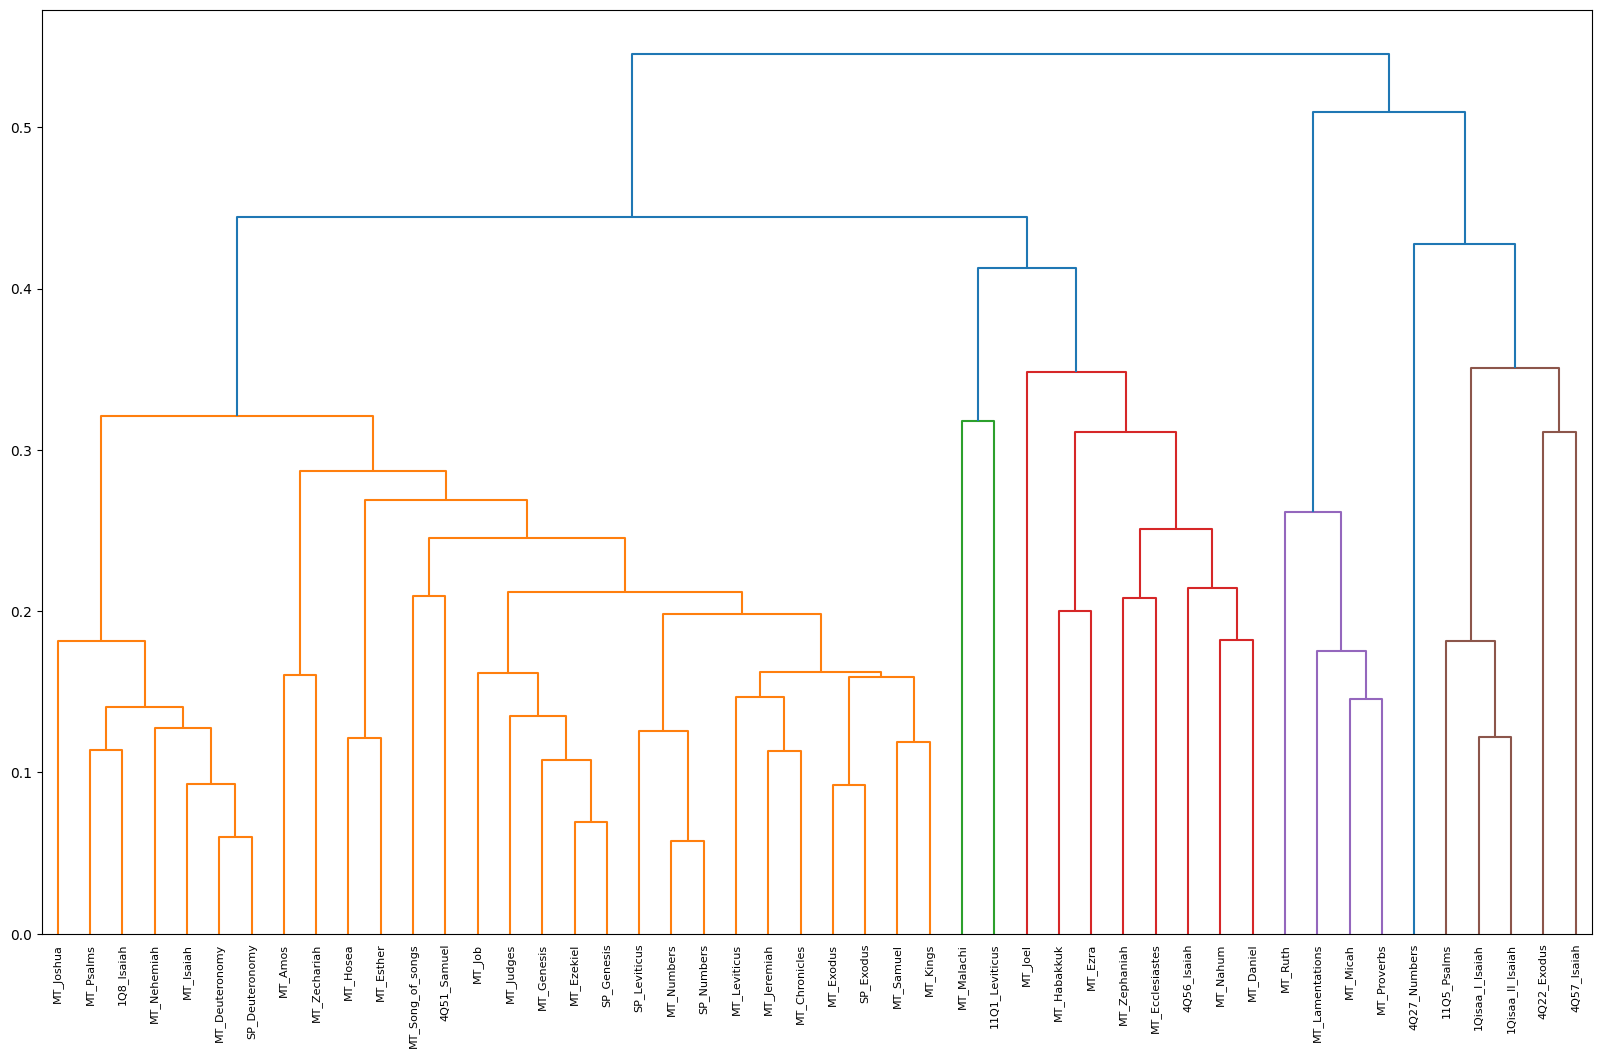

In [26]:
linkage_data = linkage(counts_tf_idf_norm, method='ward', metric='euclidean')

plt.figure(figsize=(20, 12))
dendrogram(linkage_data, labels=counts.index)
plt.show()